# Planner Testing Simulator
This simulator is used to test planning on a given map with various types of noise added. Whenver planning fails, the simulator pauses and shows the specific case where planning fail which is reproducible since our planner is deterministic. This allows for faster development and more robust planning.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from trackgen import *
from math import *
# Example of a track that is used for planning. The track is saved in a pickle
# for easy access later.

# Where are the corners?
crns = np.array( [False,True,True,False,True,True,True,False,True,True,False], dtype=bool )

# Change in angle (needs to be zero for straight)
delTh = np.array( [0,pi/2,pi/2,0,pi/2,pi/2,pi/2,0,pi/4,pi/4,0], dtype=float )

# length parameter initial guess (radius for corner, length for straight)
lpar = np.array( [20,10,-10,20,10,-10,10,200,-10,10,200], dtype=float )

track = Track( length = 200., left = True, crns = crns, rmin = 5., rmax = 15., lmax = 20., lmin = 2. )

sol = track.solve( lpar, delTh, case = 0 )

xe, ye, thcum = track.endpoint()
aveDist = 3
track.plot( cones=True, aveDist=aveDist )


NameError: name 'Track' is not defined

In [5]:
from tqdm import tqdm
import numpy as np
from scipy.interpolate import CubicSpline
from apf.planner.testvectorfield import *


def find_interval(x_points,x):
    for idx,x_val in enumerate(x_points):
        if x_val > x:
            break
    return idx-1

class SplineInterpolator:
    def __init__(self):
        pass

    def fit(self,x_points,y_points):
        self.x_points = x_points
        self.spline = CubicSpline(x_points,y_points,bc_type="natural")
        self.coeffs = self.spline.c

    def evaluate(self,x):
        '''
        Parameters
        ----------
        x_points: list (or np.array) of floats
            Sorted ascendingly list of x values for points spline is fitted on
        '''
        # Improve by using binary search
        interval = find_interval(self.x_points,x)

        if interval < 0 or interval > self.coeffs.shape[1]:
            print("WARNING: Evaluating spline outside its bounds at value {}".format(x))
            
        if interval < 0: interval = 0
        
        ans = 0
        c = self.coeffs[:,interval]
        x -= self.x_points[interval]

        for idx,cv in enumerate(c[::-1]):
            ans += cv*(x**idx)
        
        return ans
    
class ArcLengthSpline:
    '''
    This class fits a parametric third order spline as a function of arclength
    Note: it also resamples the given points in order to have equal distances (euclidean) between each two knots
    Parameters
    ----------
        num_samples: int
            The number of knots create when resampling
        arclength_dt: float
            The delta time used when estimated the arclength
    Attributes
    ----------
    '''
    def __init__(self,num_samples=50,arclength_dt=0.01):
        self.arclength_dt = arclength_dt
        self.num_samples = num_samples

    def fit_spline(self,x_points,y_points, plot=False):
        # Create initial spline objects
        self.x_spline = SplineInterpolator()
        self.y_spline = SplineInterpolator()
        
        # Fit initial splines
        self.t_points = np.arange(0,x_points.shape[0])
        self.x_spline.fit(self.t_points,x_points)
        self.y_spline.fit(self.t_points,y_points)

        # Get arclengths of the whole spline
        arclengths,t_vals = self.compute_total_arclength()
        total_arclength = np.sum(arclengths)
        self.total_arclength = total_arclength

        self.delta_arclength = total_arclength/self.num_samples

        # Resample using self.delta_arclength between each two points
        new_t_vals = [0]  # Will have arclength from start to each point
        current_theta = self.delta_arclength
        new_x_points = [self.x_spline.evaluate(0)]
        new_y_points = [self.y_spline.evaluate(0)]

        for idx in range(arclengths.shape[0]):
            if arclengths[:idx].sum()>=current_theta or idx==arclengths.shape[0]-1:
                current_theta += self.delta_arclength
                new_t_val = t_vals[idx-1]
                new_t_vals.append(arclengths[:idx].sum())
                new_x_points.append(self.x_spline.evaluate(new_t_val))
                new_y_points.append(self.y_spline.evaluate(new_t_val))
                
        new_x_points = np.array(new_x_points)
        new_y_points = np.array(new_y_points)

        # Create new spline objects to fit resampled points
        self.x_spline = SplineInterpolator()
        self.y_spline = SplineInterpolator()
        
        # Fit using resampled points
        self.x_spline.fit(new_t_vals,new_x_points)
        self.y_spline.fit(new_t_vals,new_y_points)
        self.t_points = new_t_vals
        self.x_coeffs = self.x_spline.coeffs
        self.y_coeffs = self.y_spline.coeffs
        
        # Get resampled points from the fitted splines
        points = []
        for i in range(self.num_samples):
            theta = self.delta_arclength*i
            x,y = self.x_spline.evaluate(theta), self.y_spline.evaluate(theta)
            points.append([x,y])
        points = np.array(points)
        if plot:
            # Plot the points
            plt.title("Resampled points")
            plt.scatter(points[:,0],points[:,1])
            plt.xlabel("X (m)")
            plt.ylabel("Y (m)")
            plt.show()
        return points

    def evaluate(self,theta):
        interval = int(theta//self.delta_arclength)
        ans_x, ans_y = 0,0
        cx = self.x_coeffs[:,interval][::-1]
        cy = self.y_coeffs[:,interval][::-1]
        d_theta = theta-interval*self.delta_arclength

        for idx in range(cx.shape[0]):
            poly_term = d_theta**idx
            ans_x += cx[idx]*poly_term
            ans_y += cy[idx]*poly_term
        
        return ans_x, ans_y

    def estimate_interval_arclength(self,interval):
        '''
        Estimates the arclength of one cubic parameteric curve from the splines
        Parameters
        ----------
        interval: int
        Returns
        -------
        lengths: np.array of floats
            Arclengths between points on the given parameteric curve that are self.arclength_dt apart
        t_vals: np.array of floats
            The values of t on points on the given parameteric curve that are self.arclength_dt apart
        '''
        x_coeffs = self.x_spline.coeffs[:,interval][::-1]
        y_coeffs = self.y_spline.coeffs[:,interval][::-1]

        t_vals = np.arange(interval,interval+1+self.arclength_dt,self.arclength_dt) - interval

        # Evalute the splines at points t_vals
        points_x = np.zeros(t_vals.shape[0])
        points_y = np.zeros(t_vals.shape[0])
        for idx in range(x_coeffs.shape[0]):
            points_x += x_coeffs[idx]*(t_vals**idx)
            points_y += y_coeffs[idx]*(t_vals**idx)

        # Calculate the distance between each 2 consecutive points
        x_diffs = points_x[:-1] - points_x[1:]
        y_diffs = points_y[:-1] - points_y[1:]
        x_diffs *= x_diffs
        y_diffs *= y_diffs
        dist_sums  = x_diffs + y_diffs
        lengths = np.sqrt(dist_sums)

        t_vals = t_vals[:-1] + interval

        return lengths, t_vals

    def compute_total_arclength(self):
        '''
        Estimate the arclength of the whole spline (all of the cubic polynomials fitted)
        Returns
        -------
        arclengths: np.array of floats
            Arclengths between points on the fitted spline that are self.arclength_dt apart
        t_vals: np.array of floats
            The values of t on points on the fitted spline that are self.arclength_dt apart
        '''
        arclengths = []
        t_vals = []
        for i in range(self.t_points.shape[0]-1):
            interval_arclengths,interval_t_vals = self.estimate_interval_arclength(i)

            arclengths.extend(interval_arclengths.tolist())
            t_vals.extend(interval_t_vals.tolist())
        
        arclengths = np.array(arclengths)
        t_vals = np.array(t_vals)

        return arclengths, t_vals

    
def get_obs(cones, pos, angle, obs_dist):
    dist_b = np.linalg.norm(cones-pos.reshape(1,2), axis=1)
    to_return = cones[dist_b<obs_dist]-pos.reshape(1,2)
    
    # transform angle distance
    c = np.cos(angle)
    s = np.sin(angle)
    r = np.array([[c,s],[-s,c]])
    to_return = (r@to_return.transpose()).transpose()
    
    # remove cones behind
    to_return = to_return[to_return[:,0]>0]
    to_return = to_return[np.abs(to_return[:,1])<4]
    
    return to_return

def noise_drop(cones, noise, drop_prob):
    cones += np.random.normal(0,noise,cones.shape)
    rands = np.random.uniform(0,1,cones.shape[0])
    return cones[rands>drop_prob]
class Landmark:
    def __init__(self, x, y, t, l_prob=0.8):
        self.x = x
        self.y = y
        self.color_probs = [0.33, 0.33, 0.33]
        if t==0:
            self.color_probs = [l_prob,(1-l_prob)/2,(1-l_prob)/2]
        elif t==1:
            self.color_probs = [(1-l_prob)/2,l_prob,(1-l_prob)/2]
            
    def __repr__(self):
        return '[' + str(self.x) + ", " + str(self.y) + ']'
def noise_landmarks(cones_yellow, cones_blue, false_cones, params):
    cones_yellow = noise_drop(cones_yellow, params['cone_noise'], params['cone_drop_prob'])
    cones_blue = noise_drop(cones_blue, params['cone_noise'], params['cone_drop_prob'])
    landmarks = []
    blue_type = 0
    yellow_type = 1
    if not params['yellow_color']:
        yellow_type = 3
    if not params['blue_color']:
        blue_type = 3
        
    color_conf = params['color_conf_base']
    for cone in cones_yellow:
        color_conf_noise = np.random.uniform(-params['color_conf_noise'], params['color_conf_noise'])
        landmark = Landmark(cone[0], cone[1], yellow_type,color_conf+color_conf_noise)
        landmarks.append(landmark)
    for cone in cones_blue:
        color_conf_noise = np.random.uniform(-params['color_conf_noise'], params['color_conf_noise'])
        landmark = Landmark(cone[0], cone[1], blue_type, color_conf+color_conf_noise)
        landmarks.append(landmark)
        
    for cone in false_cones:
        landmark = Landmark(cone[0], cone[1], 3, 0.5)
        landmarks.append(landmark)
        
        
    return landmarks

def test(track, params):
    '''
    Used to test the planner on a given track with given noise parameters
    '''
    car_pos = np.array([0,0]).astype(np.float)
    car_angle = np.pi
    
    s = ArcLengthSpline(num_samples=200)
    centerline = s.fit_spline(track.xm, track.ym)
    center = np.mean(centerline, axis=0)
    
    false_cones_x = np.random.normal(center[0],params['variance_external_cones'], params['n_external_cones'])
    false_cones_y = np.random.normal(center[1],params['variance_external_cones'], params['n_external_cones'])
    false_cones = np.array([false_cones_x, false_cones_y]).transpose()
    dists = np.linalg.norm(false_cones.reshape(-1,1,2)-centerline.reshape(1,-1,2), axis=2)
    min_dists = np.min(dists, axis=1)
    false_cones = false_cones[min_dists>2.5]
    
    cones_yellow = np.array([track.xc1, track.yc1]).transpose()
    cones_blue = np.array([track.xc2, track.yc2]).transpose()
    plt.plot(centerline[:,0], centerline[:,1])
    plt.scatter(false_cones[:,0], false_cones[:,1])
    plt.show()
    
    n_steps = params['n_steps']
    dt = 0.5
    car_v = 1.5
    path = []
    losses = []

    for _ in tqdm(range(n_steps), position=0, leave=True):
        path.append(np.copy(car_pos))
        
        # Get observations
        obs_blue = get_obs(cones_blue, car_pos, car_angle, params['visibility'])
        obs_yellow =  get_obs(cones_yellow, car_pos, car_angle, params['visibility'])
        obs_false =  get_obs(false_cones, car_pos, car_angle, params['visibility'])
        
        # Add noise
        landmarks = noise_landmarks(obs_yellow, obs_blue, obs_false, params)



        landmarks= np.array([landmarks])
        landmarks= landmarks.flatten()
        Land= np.array([landmarks[0].x,landmarks[0].y])
        for landmark in landmarks:
            Land=np.vstack([Land,[landmark.x,landmark.y]])
   
        
        
        # Run planning
        if len(landmarks) > 0:
            # m = Map(landmarks)
            Land = np.unique(Land,axis=0)
            print("cones = np.",repr(Land))
            indices = np.argsort(obs_blue[:, 0])
            obs_blue = obs_blue[indices]
            indices_y = np.argsort(obs_yellow[:, 0])
            obs_yellow = obs_yellow[indices_y]
            print("obsYellow = np.",repr(obs_yellow))
            print("obsBlue = np.",repr(obs_blue))
            apf= APF((0,0),(0,0),Land, 3.5,30,2.0,0.2,20,0.2,obs_yellow,obs_blue,False)
            # apf.path_plan()
            # it plots the path in the map
            # fig = plt.figure()
            apf.pathPlanPlot()
            # plt.show()
            # ways, all_paths = m.get_path()
            ways= apf.path
            next_waypoint = ways[1]
            next_waypoint = np.array([next_waypoint[0], next_waypoint[1]])
        
        # Get car direction
        c = np.cos(car_angle)
        s = np.sin(car_angle)
        r = np.array([[c,-s],[s,c]])
        direction = (r@next_waypoint.reshape(2,1)).reshape(-1)
        direction_norm = direction/np.linalg.norm(direction)

        # Move car
        car_pos += car_v*direction_norm*dt
        new_heading = np.arctan2(direction[1], direction[0])
        car_angle = new_heading
        
        # Distance to centerline
        w = direction.reshape(1,2)+car_pos.reshape(1,2)
        dists = np.linalg.norm(w-centerline, axis=1)
        min_dist = np.min(dists)
     
        losses.append(min_dist)
        if min_dist > params['success_max_dist']: # Failed
            print("LARGER THAN MIN DIST")
            path = np.array(path)
            # print(path)
            plt.plot(path[:,0], path[:,1])
            plt.show()
            #print(car_pos)
            #print(car_angle)
            return False, path, losses, landmarks
        
        # Car position noise
        car_pos += np.random.normal(0,params['car_noise'],2)
        # print(car_pos)
    
    return True, path, losses, None # Success

ModuleNotFoundError: No module named 'apf'

/tmp/ipykernel_4424/469458149.py:263: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  car_pos = np.array([0,0]).astype(np.float)


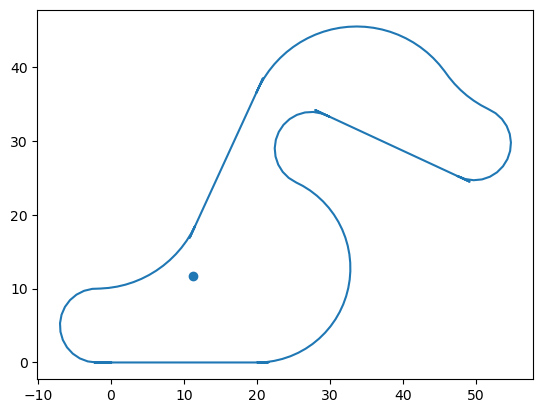

  0%|          | 0/1000 [00:00<?, ?it/s]


cones = np. array([[ 0.0905695 , -1.5318124 ],
       [ 0.11897768,  1.55963946],
       [ 1.8896834 , -1.68977753],
       [ 1.96757943,  1.53670828],
       [ 4.55756264, -2.51767882],
       [ 4.98011587,  0.71314165]])
obsYellow = np. array([[ 0.0905695 , -1.5318124 ],
       [ 1.8896834 , -1.68977753],
       [ 4.55756264, -2.51767882]])
obsBlue = np. array([[0.11897768, 1.55963946],
       [1.96757943, 1.53670828],
       [4.98011587, 0.71314165]])
two sides
3.0915823778259526
too close
too close
too close


IndexError: invalid index to scalar variable.

In [ ]:

params = {
    'cone_noise':0.1,
    'cone_drop_prob':0.002,
    'car_noise':0.002,
    'visibility': 6,
    'yellow_color': True,
    'blue_color': True,
    'p_wrong_color': 0.0001, # not working yet
    'color_conf_base':0.8,
    'color_conf_noise':0.1,
    'success_max_dist':1.0, 
    #if max distance between waypoint and centre line of path>1 stop sim
    #changed it from 1 to 0.5
    'n_steps':1000,
    'n_external_cones':1,
    'variance_external_cones':20
}
res, path, losses, landmarks = test(track, params)
#adds random cones in random places to increase noise



In [ ]:
from src.planner.testvectorfield import *
# cones=[[ 1.5875468 , -0.45779135],
#  [ 1.5875468 , -0.45779135],
#  [ 3.1082973 , -2.93498109],
#  [ 7.16653027 ,-1.89177407],
#  [ 5.00480959 ,-0.08662938],
#  [ 2.60921121 , 1.46721504],
#  [ 0.20955218 , 3.03422795],
#  [ 8.8992725  , 0.62346033],
#  [ 6.61522461 , 2.39431318],
#  [ 4.24314488 , 3.97900792]]

# cones=  [[ 3.9881277  ,-2.88461401],
#  [ 3.9881277  ,-2.88461401],
#  [ 2.30632741, -0.57890313],
#  [ 0.62595263,  1.73923805]]
cones =  [[ 0.3987178 ,  3.27085842],
 [ 0.9714083  , 0.66590311],
 [ 2.44720435, -1.8012168 ],
 [ 8.36534281 , 2.42342759]]
obs_yellow =  [[ 0.3987178  , 3.27085842],
 [ 0.9714083 ,  0.66590311],
 [ 2.44720435 ,-1.8012168 ],
 [ 8.36534281 , 2.42342759]]
obs_blue =  []




# cones=[
# [3.92826856, -3.49371632],
#  [ 3.92826856 ,-3.49371632],
#  [ 1.28005855, -2.42608722],
#  [ 7.3338318 , -2.05649972],
#  [ 4.8259136 , -0.60354334],
#  [ 2.64060721 , 0.24786245],
#  [ 0.63214954 , 1.49300995]]

# cones=[[ 5.53836143, -2.51868682],
#  [ 5.53836143 ,-2.51868682],
#  [ 3.61584564 ,-0.63777277],
#  [ 0.93321169 ,-0.70092182],
#  [ 8.72157267 ,-2.73681615],
#  [ 7.57882191 ,-0.06600842],
#  [ 5.38606079 , 1.82520035],
#  [ 2.59325377 , 2.58234792]]
# cones=[[ 3.71749492, -3.84536429],
#  [ 3.71749492 ,-3.84536429],
#  [ 1.13748772 ,-2.60297448],
#  [ 7.20795888, -2.64805084],
#  [ 4.79633932 ,-1.05405238],
#  [ 2.68369942 ,-0.01693126],
#  [ 0.76538879 , 1.34595671]]
apf2= APF((0,0),(0,0),cones,3.0,10,2.0,0.2,100,0.2,obs_yellow,obs_blue,True)
apf2.path_plan()


In [ ]:
# # Show the cones for the failed case
# for l in landmarks:
#     print(l)
#     print(l.color_probs) #if color prob are all = 0.33 therefore all are unknown
#     #if number is closer to 0.8 therefore yellow

In [ ]:
from src.planner.testvectorfield import *
# Shows planner details of the failed case
#prints cost of waypoints and cost of paths
# m = Map(landmarks)
kRepulsive = 1.0  # repulsive force constant
kAttractive = 0.8  # attractive force constant
repulsiveField = 3  # radius of obstacles
stepSize = 0.2  # step size used for updating position
maxIterations = 900  # maximum number of Iterations

# Start position
start = (2.5, 0)
goal=(0,0)

# ways, all_paths = m.get_path()

import matplotlib.pyplot as plt
%matplotlib inline


landmarks_p = np.array([[o[0],o[1]] for o in obstacle])
# waypoints = np.array([[w[0], w[1]] for w in apf.path])
apf = APF(
        (0, 2),
        goal,
        landmarks_p,
        1.0,
        0.8,
        2.0,
        0.07,
        500,
        0.2,
    )
apf.path_plan()

# # print(ways.get_cost())
plt.scatter(landmarks_p[:,0], landmarks_p[:,1])
# plt.scatter(waypoints[:,0],waypoints[:,1])
waypoints2 = np.array([[w[0], w[1]] for w in apf.path])
# plt.plot(waypoints2[:,0],waypoints2[:,1])
plt.show()
# print(len(all_paths))
# for p in apf.path:

#     # plt.scatter(waypoints[:,0],waypoints[:,1])
#     waypoints2 = np.array([[w.x, w.y] for w in p.])
#     # print(p.get_cost())
#     plt.plot(waypoints2[:,0],waypoints2[:,1])
#     plt.show()
#path starts from (0,0)
#numbers are returned values from path,py

In [ ]:
obs_blue=[]
print(np.any(obs_blue))



In [ ]:
import numpy as np 
counter=0
obs_blue = np.array( [
    [6.84183096, -3.51272817],
    [7.5324541, -0.81389686],
    [8.01345104, 2.11691751],
])
cones = np.array([
    [1.0601593, 0.04279657],
    [2.82752792, 2.63033902],
    [3.91845077, -3.19923087],
    [4.43419803, -0.30505853],
    [4.81127696, 2.51247051],
    [6.84183096, -3.51272817],
    [7.5324541, -0.81389686],
    [8.01345104, 2.11691751],
])
for ob in obs_blue:
    if ob in cones:
        cones = cones[
                    (cones != ob).all(axis=1)
                        ]
print(cones)